In [1]:
!pip install scanpy anndata umap-learn matplotlib pandas scipy
!pip install cupy-cuda12x --extra-index-url=https://pypi.nvidia.com
!pip install python-igraph louvain --quiet
!pip install leidenalg --quiet
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sb
import umap
import scanpy as sc
import cupy as cp
import os
from google.colab import drive
import zipfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.6 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving GSM8552950_PA11-2.zip to GSM8552950_PA11-2.zip


In [3]:
import zipfile

with zipfile.ZipFile("GSM8552950_PA11-2.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import os

print("Top level:", os.listdir("GSM8552950_PA11-2"))

Top level: ['.DS_Store', 'filtered_feature_bc_matrix.h5', 'spatial']


In [5]:
data_path = "GSM8552950_PA11-2/GSM8552950_PA11-2"

In [6]:
import os

spatial_dir = "GSM8552950_PA11-2/spatial"
print("Files in spatial/:", os.listdir(spatial_dir))

Files in spatial/: ['scalefactors_json.json', 'tissue_lowres_image.png', 'spatial_enrichment.csv', 'tissue_positions.csv', 'aligned_tissue_image.jpg', 'cytassist_image.tiff', 'aligned_fiducials.jpg', 'detected_tissue_image.jpg', 'tissue_hires_image.png']


In [7]:
import scanpy as sc

adata = sc.read_visium("GSM8552950_PA11-2", load_images=True)
adata.var_names_make_unique()
adata_orig = adata.copy()

/tmp/ipython-input-3721624747.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium("GSM8552950_PA11-2", load_images=True)
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
print("adata.obs columns:")
print(adata.obs.columns)
print(adata.obs.head())

adata.obs columns:
Index(['in_tissue', 'array_row', 'array_col'], dtype='object')
                    in_tissue  array_row  array_col
AACACCTACTATCGAA-1          1          0        122
AACACGTGCATCGCAC-1          1         76         22
AACACTTGGCAAGGAA-1          1         47         71
AACAGGAAGAGCATAG-1          1         69          7
AACAGGATTCATAGTT-1          1         49         43


In [9]:
import pandas as pd

df = pd.read_csv("GSM8552950_PA11-2/spatial/tissue_positions.csv", header=None)

df.columns = ["barcode", "in_tissue", "array_row", "array_col", "pxl_row_in_fullres", "pxl_col_in_fullres"]

df = df.set_index("barcode")

df_matched = df.loc[adata.obs_names]

adata.obsm["spatial"] = df_matched[["pxl_row_in_fullres", "pxl_col_in_fullres"]].to_numpy()

print("adata shape:", adata.shape)
print("obsm keys:", adata.obsm_keys())
print("spatial shape:", adata.obsm['spatial'].shape)


adata shape: (4990, 18085)
obsm keys: ['spatial']
spatial shape: (4990, 2)


In [10]:
print(os.listdir("GSM8552950_PA11-2"))
print(os.listdir("GSM8552950_PA11-2/spatial"))

['.DS_Store', 'filtered_feature_bc_matrix.h5', 'spatial']
['scalefactors_json.json', 'tissue_lowres_image.png', 'spatial_enrichment.csv', 'tissue_positions.csv', 'aligned_tissue_image.jpg', 'cytassist_image.tiff', 'aligned_fiducials.jpg', 'detected_tissue_image.jpg', 'tissue_hires_image.png']


In [11]:
def pad_columns_to_multiple_of_M(X, M):
    n_rows, n_cols = X.shape
    remainder = n_cols % M
    if remainder == 0:
        return X
    pad_n = M - remainder
    padding = np.zeros((n_rows, pad_n))
    return np.hstack([X, padding])

In [12]:
def build_dwt_matrix(signal_length, M, filters):
        k = signal_length // M
        Lf = len(filters[0])
        W = cp.zeros((signal_length, signal_length), dtype=cp.float32)
        for band in range(M):
            h = cp.asarray(filters[band], dtype=cp.float32)
            for i in range(k):
                row = band * k + i
                cols = [(i * M + j) % signal_length for j in range(Lf)]
                W[row, cols] = h
        Q, _ = cp.linalg.qr(W.T)
        return Q.T

In [13]:
all_filters = {
    (3, 2): [
        np.array([ 0.33838609728386, 0.53083618701374, 0.72328627674361, 0.23896417190576, 0.04651408217589, -0.14593600755399 ]),
        np.array([-0.11737701613483, 0.54433105395181, -0.01870574735313, -0.69911956479289, -0.13608276348796,  0.42695403781698 ]),
        np.array([ 0.40363686892892, -0.62853936105471, 0.46060475252131, -0.40363686892892, -0.07856742013185,  0.24650202866523 ])
    ],
    (4, 2): [
        np.array([-0.067371764, 0.094195111, 0.40580489, 0.567371764, 0.567371764, 0.40580489, 0.094195111, -0.067371764]),
        np.array([-0.094195111, 0.067371764, 0.567371764, 0.40580489, -0.40580489, -0.567371764, -0.067371764, 0.094195111]),
        np.array([-0.094195111, -0.067371764, 0.567371764, -0.40580489, -0.40580489, 0.567371764, -0.067371764, -0.094195111]),
        np.array([-0.067371764, -0.094195111, 0.40580489, -0.567371764, 0.567371764, -0.40580489, 0.094195111, 0.067371764])
    ],
    (4, 4): [
        np.array([0.08571302, 0.1931394393, 0.3491805097, 0.5616494215, 0.4955029828, 0.4145647737, 0.2190308939, -0.1145361261,
                  -0.0952930728, -0.1306948909, -0.0827496793, 0.0719795354, 0.0140770701, 0.0229906779, 0.0145382757, -0.0190928308]),
        np.array([-0.1045086525, 0.1183282069, -0.1011065044, -0.0115563891, 0.6005913823, -0.2550401616, -0.4264277361, -0.0827398180,
                  0.0722022649, 0.2684936992, 0.1691549718, -0.4437039320, 0.0849964877, 0.1388163056, 0.0877812188, -0.1152813433]),
        np.array([0.2560950163, -0.2048089157, -0.2503433230, -0.2484277272, 0.4477496752, 0.0010274000, -0.0621881917, 0.5562313118,
                  -0.2245618041, -0.3300536827, -0.2088643503, 0.2202951830, 0.0207171125, 0.0338351983, 0.0213958651, -0.0280987676]),
        np.array([0.1839986022, -0.6622893130, 0.6880085746, -0.1379502447, 0.0446493766, -0.0823301969, -0.0923899104, -0.0233349758,
                  0.0290655661, 0.0702950474, 0.0443561794, -0.0918374833, 0.0128845052, 0.0210429802, 0.0133066389, -0.0174753464])
    ]
}

In [14]:
def run_wavelet_pipeline(X, M, L):
    original_n_cols = X.shape[1]
    X = pad_columns_to_multiple_of_M(X, M)
    n_rows, n_cols = X.shape
    filters = all_filters[(M, L)]

    X_gpu = cp.asarray(X, dtype=cp.float32)
    W_gpu = build_dwt_matrix(n_cols, M, filters)

    print("X shape:", X_gpu.shape)
    print("W shape:", W_gpu.shape)
    print("Estimated W @ W.T size (GB):", (W_gpu.shape[0]**2 * 4) / 1e9)

    # Orthonormality check
    W_check = W_gpu @ W_gpu.T
    I_check = cp.eye(W_gpu.shape[0], dtype=cp.float32)
    print("W @ W.T max diff from I:", float(cp.max(cp.abs(W_check - I_check))))

    W1_check = W_gpu.T @ W_gpu
    I_check = cp.eye(W_gpu.shape[1], dtype=cp.float32)
    print("W.T @ W max diff from I:", float(cp.max(cp.abs(W1_check - I_check))))
    np.allclose(np.linalg.norm(X_gpu @ W_gpu.T), np.linalg.norm(X), rtol=1e-2)

    k = W_gpu.shape[0] // M
    reconstructions = []

    for i in range(M):
        W_band = W_gpu[i * k:(i + 1) * k, :]
        C_band = X_gpu @ W_band.T
        A_band = C_band @ W_band
        A_band = A_band[:, :original_n_cols]
        reconstructions.append(A_band.get())

    return reconstructions

In [15]:
import scipy.sparse as sparse
import numpy as np
import scanpy as sc

adata = adata.copy()
adata.var_names_make_unique()

if not sparse.isspmatrix_csr(adata.X):
    adata.X = adata.X.tocsr()

assert adata.X.shape[1] == adata.var.shape[0], "Gene dimension mismatch!"

row_sums = np.array(adata.X.sum(axis=1)).flatten()
row_factors = 1e4 / np.maximum(row_sums, 1e-8)
adata.X = adata.X.multiply(row_factors[:, None]).tocsr()
adata.X.data = np.log1p(adata.X.data)
adata.X = adata.X.tocsr()

sc.pp.calculate_qc_metrics(adata, inplace=True, qc_vars=[])
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_cells(adata, min_counts=1000)
print("Filtered shape:", adata.shape)

Filtered shape: (4988, 18050)


In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

In [17]:
print("adata.X shape:", adata.X.shape)
print("adata.obs shape:", adata.obs.shape)
print("adata.var shape:", adata.var.shape)

adata.X shape: (4988, 18050)
adata.obs shape: (4988, 13)
adata.var shape: (18050, 14)


In [18]:
adata = adata[:, adata.var.highly_variable]
dense_matrix = adata.X.toarray()
print(f"Remaining cells: {adata.n_obs}")

hvg_genes = adata.var_names.tolist()
with open("hvg.txt", "w") as f:
    for gene in hvg_genes:
        f.write(gene + "\n")
files.download("hvg.txt")

row_mask = ~((dense_matrix == 0).all(axis=1))
X_filtered = dense_matrix[row_mask]

views1 = run_wavelet_pipeline(X_filtered, 3, 2)
views2 = run_wavelet_pipeline(X_filtered, 4, 2)

Remaining cells: 4988


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

X shape: (4988, 3000)
W shape: (3000, 3000)
Estimated W @ W.T size (GB): 0.036
W @ W.T max diff from I: 1.0728836059570312e-06
W.T @ W max diff from I: 9.5367431640625e-07
X shape: (4988, 3000)
W shape: (3000, 3000)
Estimated W @ W.T size (GB): 0.036
W @ W.T max diff from I: 1.0728836059570312e-06
W.T @ W max diff from I: 7.152557373046875e-07


In [ ]:
spot_ids = adata.obs_names[row_mask]

for i, view in enumerate(views1):
    filename = f"wavelet_3band_2reg_view{i}_for_r.csv"
    df_view = pd.DataFrame(view, index=spot_ids, columns=hvg_genes)
    df_view.to_csv(filename)
    files.download(filename)

for i, view in enumerate(views2):
    filename = f"wavelet_4band_2reg_view{i}_for_r.csv"
    df_view = pd.DataFrame(view, index=spot_ids, columns=hvg_genes)
    df_view.to_csv(filename)
    files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#done
filename = f"withoutdwt_for_r.csv"
df_view = pd.DataFrame(view, index=spot_ids, columns=hvg_genes)
df_view.to_csv(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
spot_ids = adata.obs_names[row_mask]
pd.Series(spot_ids).to_csv(f"spots.csv", index=False, header=False)
files.download(f"spots.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

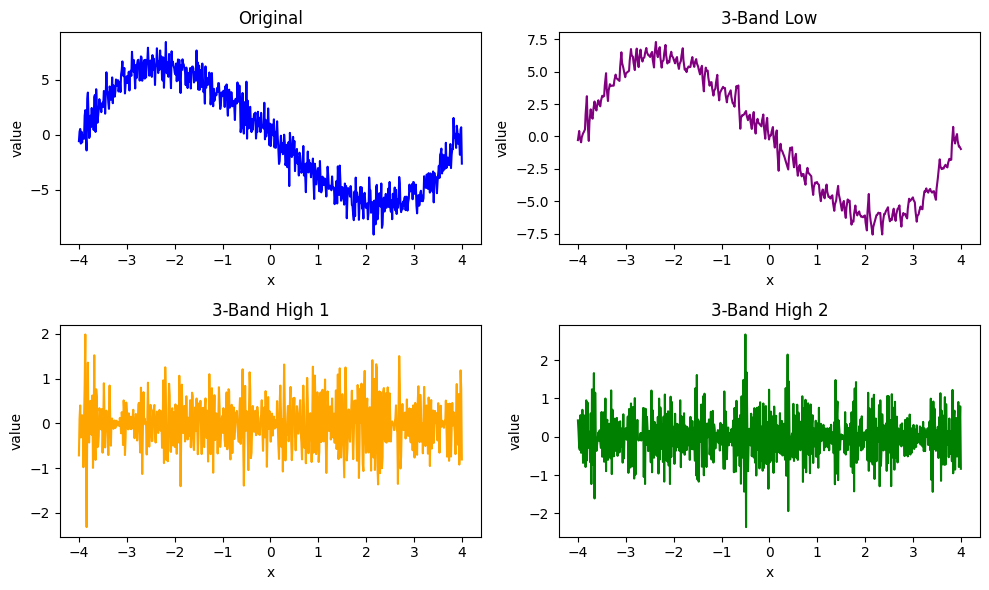

In [25]:
no_dmwt_label = "Original"
y_dmwt = {f"Band {i+1}": bands[i][0].astype(float) for i in range(3)}
y_dmwt[no_dmwt_label] = y

label_map = {
    "Original": "Original",
    "Band 1": "3-Band Low",
    "Band 2": "3-Band High 1",
    "Band 3": "3-Band High 2"
}

plot_keys   = ["Original", "Band 1", "Band 2", "Band 3"]
plot_colors = ["blue", "purple", "orange", "green"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes = axes.flatten()

for key, ax, color in zip(plot_keys, axes, plot_colors):
    ax.plot(x, y_dmwt[key], color=color)
    ax.set_title(label_map[key])
    ax.set_xlabel("x")
    ax.set_ylabel("value")

fig.tight_layout()
fig.savefig("wavelet_plot.png", dpi=600)

from google.colab import files
files.download("wavelet_plot.png")

In [33]:
import json, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import matplotlib.patheffects as pe
from google.colab import files
import matplotlib.image as mpimg

spatial_dir = "GSM8552950_PA11-2/spatial"

img_hires = mpimg.imread(f"{spatial_dir}/tissue_hires_image.png")
with open(f"{spatial_dir}/scalefactors_json.json") as f:
    sf = json.load(f)

tissue_hires_scalef  = float(sf["tissue_hires_scalef"])
spot_diam_fullres_px = float(sf["spot_diameter_fullres"])

sp_fullres = np.asarray(adata.obsm["spatial"], dtype=float)
xy_fullres = sp_fullres[:, [1, 0]]
xy_hires   = xy_fullres * tissue_hires_scalef

spot_diam_hires_px = spot_diam_fullres_px * tissue_hires_scalef
spot_radius_px     = spot_diam_hires_px / 2.0

PHYS_SPOT_DIAM_UM = 55.0
scalebar_um       = 500
px_per_um_hires   = (spot_diam_fullres_px / PHYS_SPOT_DIAM_UM) * tissue_hires_scalef
scalebar_px       = scalebar_um * px_per_um_hires

bar_height_frac   = 0.018
bar_alpha         = 1.0
bar_face          = "white"
bar_edge          = "black"
bar_edge_lw       = 2.0
label_fontsize    = 16
label_weight      = "bold"
label_color       = "white"
label_outline     = True

H, W = img_hires.shape[:2]
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
ax.imshow(img_hires)
ax.set_axis_off()

for (x, y) in xy_hires:
    ax.add_patch(Circle((x, y), radius=spot_radius_px,
                        edgecolor="red", facecolor="none", lw=0.6, alpha=0.7))

margin_px     = int(0.08 * min(H, W))
bar_height_px = max(4, int(bar_height_frac * H))
bar_x         = margin_px
bar_y         = H - margin_px - bar_height_px

ax.add_patch(Rectangle((bar_x, bar_y), scalebar_px, bar_height_px,
                       linewidth=bar_edge_lw, edgecolor=bar_edge,
                       facecolor=bar_face, alpha=bar_alpha))

txt = ax.text(bar_x + scalebar_px/2.0, bar_y - (0.9 * bar_height_px),
              f"{int(scalebar_um)} µm", ha="center", va="bottom",
              fontsize=label_fontsize, weight=label_weight, color=label_color)
if label_outline:
    txt.set_path_effects([
        pe.Stroke(linewidth=3.0, foreground='black'),
        pe.Normal()
    ])

fig.tight_layout(pad=0)
out_path = "overlay_hires_scalebar_bold.png"
fig.savefig(out_path, dpi=600, bbox_inches="tight", pad_inches=0)
plt.close(fig)
files.download(out_path)

print(f"Image (W x H): {W} x {H} px")
print(f"x range (hires): {xy_hires[:,0].min():.1f} .. {xy_hires[:,0].max():.1f}")
print(f"y range (hires): {xy_hires[:,1].min():.1f} .. {xy_hires[:,1].max():.1f}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Image (W x H): 1924 x 2000 px
x range (hires): 131.5 .. 1765.9
y range (hires): 183.1 .. 1906.6


In [ ]:
X_reconstructed = sum(views)
X_reconstructed = X_reconstructed[:, :dense_matrix.shape[1]]

error = np.linalg.norm(X_reconstructed - dense_matrix) / np.linalg.norm(dense_matrix)

print(f"Reconstruction relative error: {error:.2e}")

Reconstruction relative error: 4.12e-07
